# <center>Recommender Systems: Learning Collaborative Filtering Similarity Measures using Siamese Networks</center>

In [1]:
import math
from math import factorial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from scipy.stats import truncnorm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Step 1: Obtain the user/item vote matrix

In [2]:
df = pd.read_csv("ML_100K.data", header=None, sep="\s+",
                    usecols=[0, 1, 2], names=['user','item','rating'])

In [3]:
num_users = df.user.nunique()
min_user_id = df.user.min()
max_user_id = df.user.max()
(num_users, (min_user_id, max_user_id))

(943, (1, 943))

In [4]:
num_items = df.item.nunique()
min_item_id = df.item.min()
max_item_id = df.item.max()
(num_items, (min_item_id, max_item_id))

(1682, (1, 1682))

In [5]:
users = df.groupby(by='item')
users_items = pd.DataFrame(index=pd.RangeIndex(min_user_id, max_user_id+1), dtype='int8')
users_items.index.name = 'user'
users_items.columns.name='item'
for group in users.groups:
    ux = users.get_group(group)[['user','rating']]
    ux.set_index('user', inplace=True)
    users_items[str(group)] = ux

users_items.fillna(0, inplace=True)
users_items

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Number of votes cast/not cast

In [6]:
num_cast_votes = (users_items != 0.0).sum(axis=1)

In [7]:
num_no_cast_votes = (users_items == 0.0).sum(axis=1)

#### Minimum number of votes cast/not cast by a user

In [8]:
min_cast_votes = num_cast_votes.min()
min_no_cast_votes = num_no_cast_votes.min()
min_cast_votes, min_no_cast_votes

(20, 945)

### Paso 2: Dividir los dataset de entrenamiento/test

In [9]:
train, test = train_test_split(users_items, test_size=0.25,random_state=50)

### Paso 3: Expandir los dataset de entrenamiento/test

In [10]:
# Minimum number of votes
# can never be greater than the minimum number of votes cast by a user
min_num_votes = 10

# Maximum number of votes to modify
# can never be greater than the minimum number of votes cast by a user
max_num_modify_votes = 100

# Maximum number of votes to add
# can never be greater than the minimum number of items not voted on by a user
max_num_add_votes = 300

# Maximum number of combinations per user to generate
# depends on the number of votes cast and the number of votes to be modified/added
max_num_comb = 100

In [11]:
def number_of_combinations(m, n):
    """ 
     Calculates and returns the number of possible combinations
     that can be done with m elements taking n items at a time.
    """
    return factorial(m) // (factorial(n) * factorial(m - n))

In [12]:
def get_random_combinations(iterable, size_comb, num_comb=1):
    """ 
     Generates random samples (num_comb) from a given 1-D array (iterable)
     width a specific size (size_comb)
    """
    combinations = []
    for i in range(1, num_comb+1):
        combinations.append(np.random.choice(iterable, size_comb, replace=False).tolist())
    return combinations

In [13]:
def get_truncated_normal(mean=0, sd=1, low=1, upp=5, size=1):
    """
     Generates random integer values between low and upp, following a Gaussian(mean, sd) distribution
    """
    return np.rint(truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(size))

In [14]:
def get_modifications(user_votes):
    """
     Generate modifications on a user's vote matrix
    """
    user = user_votes.name
    # returns positions with votes (items id's - 1)
    nonzero_user_votes = user_votes.to_numpy().nonzero()[0]
    # returns positions with no votes (items id's - 1)
    zero_user_votes = (user_votes==0).to_numpy().nonzero()[0]
    
    # votes to modify
    votes_to_modify = min(max_num_modify_votes, num_cast_votes[user] - min_num_votes)
    # votes to add
    votes_to_add = min(max_num_add_votes, num_no_cast_votes[user] - min_num_votes)

    # get the number of combinations to modify
    num_modify_comb = min(max_num_comb, number_of_combinations(nonzero_user_votes.size, votes_to_modify))
    num_add_comb = min(max_num_comb, number_of_combinations(zero_user_votes.size, votes_to_add))

    # Non-repeating combinations of nonzero_user_votes taken in groups of length num_modify_comb
    modify_votes_comb = get_random_combinations(nonzero_user_votes, votes_to_modify, num_modify_comb)
    # Non-repeating combinations of nonzero_user_votes taken in groups of length num_add_comb
    add_votes_comb = get_random_combinations(zero_user_votes, votes_to_add, num_add_comb)
    
    votes_list = []
    # The original vote of the user is added
    votes_list.append(user_votes)   
    # The modifications of the original vote are obtained
    for modify_comb, add_comb in zip(modify_votes_comb, add_votes_comb):
        updated_user_votes = user_votes.copy()
        # cambios
        updated_user_votes.iloc[modify_comb] = np.absolute(
            updated_user_votes.iloc[modify_comb].values-vote_distribution[modify_comb])   
        # nuevos votos
        updated_user_votes.iloc[add_comb] = vote_distribution[add_comb]
        votes_list.append(updated_user_votes)
        
    return votes_list

#### Step 3.1: Generate a Gaussian distribution of votes

In [15]:
vote_distribution = get_truncated_normal(mean=3, size=num_items)
vote_distribution

array([4., 3., 3., ..., 3., 4., 3.])

In [16]:
x, y = np.unique(vote_distribution, return_counts=True)
x, y, sum(y)

(array([1., 2., 3., 4., 5.]), array([ 72, 416, 695, 421,  78]), 1682)

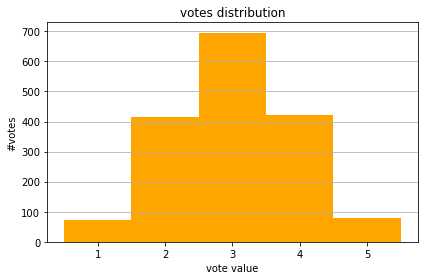

In [17]:
import matplotlib.pyplot as plt

plt.title('votes distribution')
plt.ylabel("#votes")
plt.xlabel("vote value")
plt.bar(x, y, width=1, color="orange")
plt.grid(True, axis="y")
plt.tight_layout() 
plt.show()

#### Step 3.2: Expand the votes of all training users

In [18]:
votes_list = []
for user in train.index:
    user_votes = train.loc[user]
    votes_list.extend(get_modifications(user_votes))
    
expanded_train = pd.DataFrame(votes_list, columns=users_items.columns)
expanded_train.fillna(0, inplace=True)
expanded_train

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0
863,0.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,...,0.0,0.0,2.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0
863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
863,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0
863,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,4.0,0.0,1.0,1.0,2.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0
689,1.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
689,1.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0
689,3.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Step 3.3: Expand the votes of all test users

In [19]:
votes_list = []
for user in test.index:
    user_votes = test.loc[user]
    votes_list.extend(get_modifications(user_votes))
    
expanded_test = pd.DataFrame(votes_list, columns=users_items.columns)
expanded_test.fillna(0, inplace=True)
expanded_test

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
443,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
443,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
443,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
204,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
204,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Step 3.3: Get `x_train_set` and `y_train_set`

In [20]:
# number of pairs to generate
n_pairs = 100000

In [21]:
# equal pairs of expanded training rows
equals_pairs = []
random_entries = np.random.randint(0, expanded_train.shape[0]-1, (n_pairs//2, 1))
for user_i in random_entries:
    equals_pairs.append([user_i[0], user_i[0]+1])

equals_pairs = np.array(equals_pairs)

In [22]:
# random pairs of expanded training rows
random_pairs = np.random.randint(0, expanded_train.shape[0], (n_pairs//2, 2))

In [23]:
pairs = np.concatenate([equals_pairs, random_pairs])
np.random.shuffle(pairs)

In [24]:
x_train_set = []
y_train_set = []
for user_i, user_j in pairs:
    x_train_set.append([expanded_train.iloc[user_i], expanded_train.iloc[user_j]])
    if expanded_train.iloc[user_i].name == expanded_train.iloc[user_j].name:
        y_train_set.append(1)
    else:
        y_train_set.append(0)

x_train_set = np.array(x_train_set)
y_train_set = np.array(y_train_set)

In [25]:
x_train_set.shape

(100000, 2, 1682)

In [26]:
y_train_set.shape

(100000,)

In [27]:
np.unique(y_train_set, return_counts=True)

(array([0, 1]), array([50425, 49575]))

#### Step 3.4: Get `x_test_set` and `y_test_set`

In [28]:
# equal pairs of expanded test rows
equals_pairs = []
random_entries = np.random.randint(0, expanded_test.shape[0]-1, (n_pairs//2, 1))
for user_i in random_entries:
    equals_pairs.append([user_i[0], user_i[0]+1])

equals_pairs = np.array(equals_pairs)

In [29]:
# random pairs of expanded test rows
random_pairs = np.random.randint(0, expanded_test.shape[0], (n_pairs//2, 2))

In [30]:
pairs = np.concatenate([equals_pairs, random_pairs])
np.random.shuffle(pairs)

In [31]:
x_test_set = []
y_test_set = []
for user_i, user_j in pairs:
    x_test_set.append([expanded_test.iloc[user_i], expanded_test.iloc[user_j]])
    if expanded_test.iloc[user_i].name == expanded_test.iloc[user_j].name:
        y_test_set.append(1)
    else:
        y_test_set.append(0)

x_test_set = np.array(x_test_set)
y_test_set = np.array(y_test_set)

In [32]:
x_test_set.shape

(100000, 2, 1682)

In [33]:
y_test_set.shape

(100000,)

In [34]:
np.unique(y_test_set, return_counts=True)

(array([0, 1]), array([50253, 49747]))

In [35]:
latent_dim = 20

def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((x_train_set.shape[2]))
x = layers.Dense(10, activation="relu")(input)
x = layers.Dense(latent_dim, activation="relu")(x)
embedding_network = keras.Model(input, x)
input_1 = layers.Input((x_train_set.shape[2]))
input_2 = layers.Input((x_train_set.shape[2]))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
middle_layer = layers.Dense(50, activation="relu")(merge_layer)
dr_middle_layer = layers.Dropout(0.4)(middle_layer)
output_layer = layers.Dense(1, activation="sigmoid")(dr_middle_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [36]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(1-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [37]:
epochs = 10
batch_size = 512
margin = 1

y_train_set = y_train_set.astype(np.float64)
y_test_set = y_test_set.astype(np.float64)

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

history = siamese.fit(
    [x_train_set[:,0,:], x_train_set[:,1,:]], y_train_set,
    validation_data=([x_test_set[:,0,:], x_test_set[:,1,:]], y_test_set),
    batch_size=batch_size,
    epochs=epochs,
)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1682)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1682)]       0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 20)           17050       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           functional_1[0][0]    

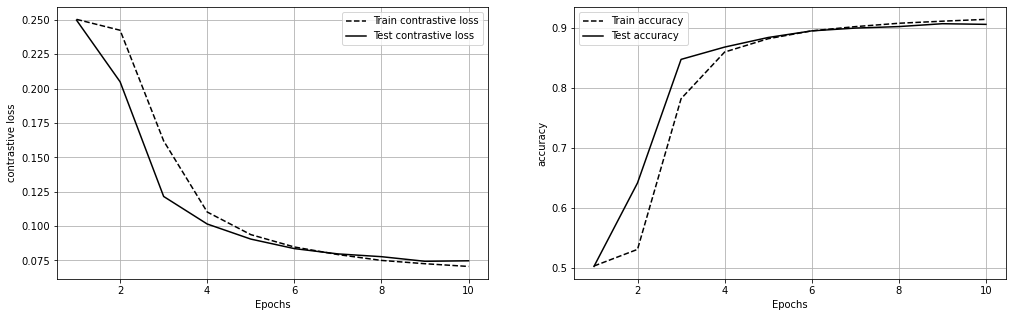

In [38]:
def plot(h,epochs):
    LOSS = 0; ACCURACY = 1
    training = np.zeros((2,epochs)); testing = np.zeros((2,epochs))
    training[LOSS] = h.history['loss']
    testing[LOSS] = h.history['val_loss']    # validation loss
    training[ACCURACY] = h.history['accuracy']
    testing[ACCURACY] = h.history['val_accuracy']  # validation accuracy

    epochs = range(1,epochs+1)
    fig, axs = plt.subplots(1,2, figsize=(17,5))
    for i, label in zip((LOSS, ACCURACY),('contrastive loss', 'accuracy')):   
        axs[i].plot(epochs, training[i], 'black', linestyle = '--', label='Train ' + label)
        axs[i].plot(epochs, testing[i], 'black', label='Test ' + label)

        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(label)
        axs[i].legend()
        axs[i].grid(True)
    plt.show()

plot(history,epochs)

### Step 4: Create test suite for similarity

In [39]:
def make_oneshot_task(n_ways=16):
    """
    Arguments:
      n_ways: Number of vectors to generate
      
    Returns:
      An two rows array with vote vectors, the first one with n_ways times the selected vector
      for the study of similarity, and a second row with vector variations, including
      the vector selected for the similarity study.
      It also returns an array indicating the position of the variation of the selected vector.
      for the similarity study in the second row.
    """
    # n_ways vectors are random selected from the test set
    # a principal vector V and n_ways-1 test vectors different from vector V
    random_vectors = np.random.choice(test.index, n_ways, replace=False)
    # we randomly choose the vector V from among the n_ways vectors 
    v_pos = np.random.choice(n_ways)
    v_index = random_vectors[v_pos]

    # the original vectors are stored in expanded_test.loc[index].iloc[0]
    # variations of the original vectors are stored in expanded_test.loc[index].iloc[1...num_comb]
    
    # in the first row we put n_ways times the vector V
    row_1 = np.array([expanded_test.loc[v_index].iloc[0] for i in range(n_ways)])
    # in the second row we put variations of the random_vectors
    row_2 = np.array([expanded_test.loc[index].iloc[1] for index in random_vectors])
    
    # return pairs, targets
    pairs = np.vstack([[row_1], [row_2]])
    targets = np.tile(0, n_ways)
    targets[v_pos] = 1
    return pairs, targets

In [40]:
def nearest_neighbour_correct(pairs,targets,similarity_measure):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    distances = similarity_measure(pairs[0,:,:],pairs[1,:,:])
    if np.argmin(distances) == np.argmax(targets):
        return 1
    return 0

def nearest_neighbour_correct_siamese(pairs,targets,similarity_measure):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    distances = similarity_measure([pairs[0,:,:],pairs[1,:,:]], verbose=0)
    if np.argmin(distances) == np.argmax(targets):
        return 1
    return 0

In [41]:
def euclidean(X,Y):
    result = np.zeros((X.shape[0]))
    for batch in range(len(X)):
        acc = 0.0
        for i in range(X.shape[0]):
            if X[batch][i] != 0 and Y[batch][i] !=0:
                acc += (X[batch][i] - Y[batch][i]) ** 2
        result[batch] = math.sqrt(acc)
    return result


def cosine(X,Y):
    result = np.zeros((X.shape[0]))
    for batch in range(len(X)):
        acc = 0.0; den1 = 0.0; den2 = 0.0
        for i in range(X.shape[0]):
            if X[batch][i] != 0 and Y[batch][i] !=0:
                acc += X[batch][i]*Y[batch][i]
                den1 += X[batch][i]**2
                den2 += Y[batch][i]**2
        if den1==0.0 or den2==0.0:
            result[batch]=0.0
        else:
            result[batch] = acc / (math.sqrt(den1)*math.sqrt(den2))
    return result
 
def jaccard(X,Y):
    result = np.zeros((X.shape[0]))
    for batch in range(len(X)):
        intersection = 0; union = 0
        for i in range(X.shape[0]):
            if X[batch][i] != 0 and Y[batch][i] !=0:
                intersection += 1
            elif not(X[batch][i] != 0 or Y[batch][i] != 0):
                union += 1

        if union == 0.0:
            result[batch]=0.0
        else:
            result[batch] = intersection / union
    return result

def msd(X,Y):
    result = np.zeros((X.shape[0]))
    for batch in range(len(X)):
        acc = 0.0; den = 0
        for i in range(X.shape[0]):
            if X[batch][i] != 0 and Y[batch][i] !=0:
                acc += (X[batch][i]-Y[batch][i])**2
                den += 1
        if den == 0:
            result[batch]=0.0
        else:
            result[batch] = acc / den
    return result

def jmsd(X,Y):
    return jaccard(X,Y) * msd(X,Y)

def manhattan(X,Y):
    result = np.zeros((X.shape[0]))
    for batch in range(len(X)):
        acc = 0.0; den = 0
        for i in range(X.shape[0]):
            if X[batch][i] != 0 and Y[batch][i] !=0:
                acc += abs(X[batch][i]-Y[batch][i])
                den += 1
        if den == 0:
            result[batch]=0.0
        else:
            result[batch] = acc / den
    return result

def correlation(X,Y):
    result = np.zeros((X.shape[0]))
    meanX = np.mean(X)
    meanY = np.mean(Y)
    for batch in range(len(X)):
        acc = 0.0; den1 = 0.0; den2 = 0.0
        for i in range(X.shape[0]):
            if X[batch][i] != 0 and Y[batch][i] !=0:
                Xm = X[batch][i]-meanX
                Ym = Y[batch][i]-meanY
                acc += Xm*Ym
                den1 += Xm**2
                den2 += Ym**2
        den = math.sqrt(den1*den2)
        if den == 0.0:
            result[batch] = 0.0
        else:
            result[batch] = 1 - (acc / den)
    return result

    

def test_nn_accuracy(N_ways,n_trials,similarity_measure, siamese):
    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways)
        if siamese:
            correct = nearest_neighbour_correct_siamese(pairs,targets,similarity_measure)
        else:
            correct = nearest_neighbour_correct(pairs,targets,similarity_measure)   
        n_right += correct
    return 100.0 * n_right / n_trials

SIAMESE = True;
N_WAYS = [4,8,16]
SIMILARITIES = ["euclidean", "correlation", "cosine", "manhattan",
                 "jaccard", "msd", "jmsd", "siamese"]
result = np.zeros((len(SIMILARITIES),len(N_WAYS)))
for s,similarity in enumerate(SIMILARITIES):
    for n,n_ways in enumerate(N_WAYS):
        if similarity == "siamese": 
            result[s][n] = test_nn_accuracy(n_ways,200,siamese.predict,SIAMESE)
        else:
            result[s][n] = test_nn_accuracy(n_ways,200,eval(similarity),not SIAMESE)
    print(similarity, result[s])

euclidean [26.5  9.5  3. ]
correlation [23.5 11.5  0.5]
cosine [18.5  6.   1. ]
manhattan [28.5 11.5  4. ]
jaccard [20.   4.5  2. ]
msd [20.5 11.5  3.5]
jmsd [19.5  9.   3. ]
siamese [35. 17. 12.]


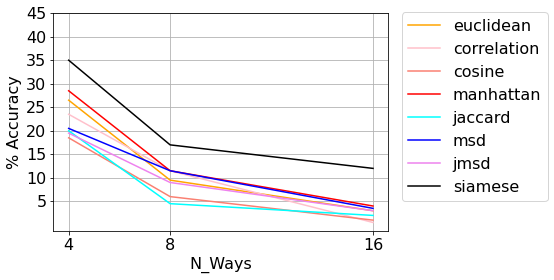

In [42]:
np.save("result-150-350.npy",result)

plt.figure()
plt.rcParams['font.size'] = '16'

colors = ['orange','pink','salmon','red','cyan','blue',"violet", "black"]
for s,similarity in enumerate(SIMILARITIES):
    plt.plot(N_WAYS, result[s],color=colors[s], label=similarity)
plt.legend(bbox_to_anchor = (1.5,1.04), loc='upper right')
plt.xticks(N_WAYS)
plt.yticks(range(5,50,5))
plt.xlabel("N_Ways")
plt.ylabel("% Accuracy")
plt.grid(True)
plt.show()